# Build the field

## Because we are not allowed to do object oriented this is the orientation of the ant:
ant[team, food, smell]

* team is a value between -1 and 1 where -1 has no ant on it 0 has ant from team 0 and 1 has ant from team 1

* food is the value of the food  where 0 is no food 1 is has food, -1 is a special case for the neighborhood function for some neighbor outside of the field

* smell - or scent is the value of the scent meaning how many ants have stepped on the square

## Another important array that we use in this is the queens array:

the queens array is a 1 dimmenssional array that looks like this: </br>

queens[team1 food, team2 food]

in the queens array is stored the food that each team's queen has

In [108]:
import numpy as np
import random
from matplotlib import pyplot as plt

In [109]:
def build_field(food_amount: int, field_size: int) -> np.ndarray:
    """returns the first of size field_size with a set amount of food food_amount"""
    assert food_amount < (field_size-1)*(field_size-1)
    field = np.zeros((field_size,field_size,3))
    field[:,:,0] = -1
    for _ in range(food_amount):
        randx = random.randint(1,field_size-2)
        randy = random.randint(0, field_size-1)
        while field[randy,randx,1] != 0:
            randx = random.randint(1,field_size-2)
            randy = random.randint(0, field_size-1)
        field[randy,randx,1] = 1  
    # return np.reshape(field,(field_size,field_size))
    return field                
      

In [110]:
def neighbors(col:int, row:int, field:np.ndarray)-> np.ndarray:
    """x - x index, y - y index\n
    this function returns a 2 dimensional array of shape(8,3) signifying every spot around the ant where every cell of the array is an ant.\n
    the array is sorted like this where 4 is the ant: \n
    0 1 2
    3 * 4
    5 6 7 
    """
    count = 0
    nei = np.zeros((8,3))
    for i in range(0,3):
        for j in range(0,3):
            if j == 1 and i ==1:
                continue
            if not(row-1+i<0 or col-1+j<0 or row-1+i>=len(field[0]) or col-1+j>=len(field[0])):
                nei[count] = field[row-1+i, col-1+j]
            else:
                nei[count] = np.zeros(3)-1
            count +=1
    return nei

# Ant operation funcitons

as we have shown before there are 5 different things that an ant could do, so these following functions will take neighborhood as input and output an array of the same size which will then be pasted into the field in the next function finally creating the next field  

In [111]:
neiToField = {
    0: [-1,-1],
    1: [0,-1],
    2: [1,-1],
    3: [-1,0],
    4: [1,0],
    5: [-1,1],
    6: [0,1],
    7: [1,1]
}
def nei_to_field(neiIndex, fieldX, fieldY):
    """does neighbor to field"""
    return  neiToField[neiIndex][1] + fieldY, neiToField[neiIndex][0] + fieldX

In [112]:
def give_food(field:np.ndarray, nei:np.ndarray, x:int, y:int) -> np.ndarray:
    """give the nearest ant around form the same team the food wich she have
        if there is no ant which capable to cary that food the original field will return"""
    
    field = field.copy()
    antWithTheHighestSmellInd = -1
    highstSmell = 0
    mainAnt = field[y,x]
    for index,i in enumerate(nei):
        if(i[0] == mainAnt[0] and highstSmell<=abs(i[2]) and i[1] == 0): #if the ant has bigger smell then all the ant around
            #and if the ant is from the same team and if the ant hasn't have any food, then it will choose it
            highstSmell = abs(i[2])
            antWithTheHighestSmellInd = index
    
    if(antWithTheHighestSmellInd == -1):
        return None #Not capable doing that
    
    xField, yField = nei_to_field(antWithTheHighestSmellInd, x, y)
    field[yField,xField][1] += 1
    field[y,x][1] = 0

    return field

In [113]:
def take_food(field:np.ndarray, nei:np.ndarray, antIndexY: int, antIndexX: int) -> np.ndarray: #only happend if the ant goes on the food
    """get the field and ant Indexes (x,y) and return the new field
     where the ant moved and takes the food
      if there is no food return None """
    field = field.copy()
    foodInd = -1
    for index in range(len(nei)):
        if(nei[index][0] == -1 and nei[index][1] == 1): #is food
            foodInd = index
            break
    
    if(foodInd == -1):
        return None
    y,x = nei_to_field(foodInd, antIndexX, antIndexY)

    field[y,x]=field[antIndexY,antIndexX].copy()
    field[antIndexY,antIndexX]=np.array([-1,0,field[y,x,2]])
    field[y,x][1]=1
    field[y,x][2]=+1*(1-2*field[y,x,0])
    return field

In [114]:
def warfare(field:np.ndarray, nei:np.ndarray, x:int, y:int):
   field = field.copy()
   team = field[y,x,0]
   for index,i in enumerate(nei): 
      if i[0] != -1 and i[0] != team:
         loc = nei_to_field(index, x,y)
         randnum = random.random()
         if randnum > 0.5: #other ant wins 
            field[y,x, 0] = 0 #kills ant
            field[loc[1], loc[0], 1] = 1 #gives other ant food (maybe) 
         else: #this ant wins 
            field[y,x][1] = 1 #gives ant food (maybe)
            field[loc[1], loc[0]][0] = 0 #kills ant
         break
   return field

In [115]:
def move_away_scent(field:np.ndarray, nei:np.ndarray, col:int, row:int) -> np.ndarray:
    nfield = field.copy()
    team = nfield[row,col,0]
    nfield[row,col,2] = nfield[row,col,2]+1*(1-2*team)
    ant = nfield[row,col].copy()
    prob = np.zeros(8)
    for index,cell in enumerate(nei):
        if cell[1] == -1:
            prob[index] = 0
        else:
            prob[index] = abs(ant[2]-cell[2])+1
    if (prob == np.zeros(8)).all():
        return nfield
    prob = prob/np.sum(prob)
    new_pos = nei_to_field(np.random.choice(8,p=prob),col,row)
    nfield[new_pos[0],new_pos[1],0] = ant[0]
    nfield[new_pos[0],new_pos[1],1] = ant[1]
    nfield[row,col] = np.array([-1,0,nfield[row,col,2]])
    return nfield

In [116]:
def move_to_scent(field:np.ndarray, nei:np.ndarray, col:int, row:int) -> np.ndarray:
    nfield = field.copy()
    team = nfield[row,col,0]
    nfield[row,col,2] = nfield[row,col,2]+1*(1-2*team)
    ant = nfield[row,col].copy()
    prob = np.zeros(8)
    for index,cell in enumerate(nei):
        if cell[1] == -1:
            prob[index] = 0
        else:
            prob[index] = abs(ant[2]-cell[2])+1
    s_max=max(prob)
    for index,p in enumerate(prob):
        if s_max+1-p==s_max+1:
            prob[index]=0
        prob[index]=s_max+1-p
    if (prob == np.zeros(8)).all():
        return nfield

    prob = prob/np.sum(prob)
    
    new_pos = nei_to_field(np.random.choice(8,p=prob),col,row)
    print(new_pos)
    nfield[new_pos[0],new_pos[1],0] = ant[0]
    nfield[new_pos[0],new_pos[1],1] = ant[1]
    nfield[row,col] = np.array([-1,0,nfield[row,col,2]])
    return nfield

# Applying the operation functions

In [117]:
def rules(col:int, row:int, field:np.ndarray) -> np.ndarray:
    global debug
    """x - x index, y - y index\n
    this functions returns an updated field,
    it chooses which of the operations to perform then returns the updated field for a given ant and applies the appropriate function the situations can be\n
    give food, \n
    take food, \n
    move to scent, \n
    warfare,\n
    move away from scent
    """
    #remember to do scent properly
    #print(f"rules:{field[x,y]}")
    nei = neighbors(col,row,field)
    newField = None
    debug = -2
    if(field[row,col,1] == 1):
        newField = give_food(field, nei, col, row) #return None if its not capable to do it
        debug = 0
        if(newField is None):
            print("test")
            newField = move_to_scent(field, nei, col, row)
            debug = 1
            return newField
    else:
        newField = take_food(field, nei, row, col) #return None if its not capable to do it
        debug = 2
        if(newField is None):
            team = field[row,col,0]
            for ant in nei:
                if ant[0] != team and ant[0] !=-1:
                    newField = warfare(field, nei, col, row)
                    debug = 3
                    return newField
            if(newField is None):
                newField = move_away_scent(field, nei, col, row)
                debug = 4
    return newField

# And finally doing the Next function

In [118]:
def give_birth(field:np.ndarray, queens:np.ndarray):
    """
    this function is the queens giving birth
    - the queen can only give birth on the three tiles on the middle of it's side but it can birth as many ants as available
    """
    mid = len(field)//2
    for i in range(-1,2):
        if field[mid+i,0,0] == -1 and queens[0] > 0:
            field[mid+i,0,0] = 0
            queens[0] -= 1
        if field[mid+i,len(field)-1,0] == -1 and queens[1]>0:
            field[mid+i,len(field)-1,0]  = 1
            queens[1] -= 1

In [119]:
def queen_eat(field:np.ndarray, queens:np.ndarray):
    """
    this funciton is the queens eating if there is an ant that has food in the beginning of the turn
    """

    mid = len(field)//2
    for i in range(-1,2):
        if field[mid+i,0,0] == 1 and field[mid+i,0,1]>0:
            queens[0] += 1
            field[mid+i,0,1] = 0
            
        if field[mid+i,len(field)-1,0] == 1 and field[mid+i,len(field)-1,1]>0:
            queens[1] += 1
            field[mid+i,len(field)-1,1] = 1

In [120]:
def next_gen(field: np.ndarray, queens: np.ndarray) -> np.ndarray:
    give_birth(field, queens)
    queen_eat(field,queens)
    debug = 0
    field = field.copy()
    for y,row in enumerate(field):
        for x,cell in enumerate(row):
            if cell[0] >= 0:
                field = rules(x,y,field)
    return field


# simulation

In [121]:
t = 100
l = 15
food_amnt = 10
queens = np.array([10,0])
simulation = np.zeros((t,l,l,3))
simulation[0] = build_field(food_amnt, l)
for i in range(1,t-1):
    next_sim = next_gen(simulation[i-1],queens)
    simulation[i-1]
    simulation[i] = next_sim.copy()

test
(13, 1)
test
(2, 2)
test
(14, 2)
test
(1, 2)
test
(15, 2)


IndexError: index 15 is out of bounds for axis 0 with size 15

In [ ]:
def make_show_sim(sim:np.ndarray):
    show_sim_dict = {
        (-1,0): 0,
        (0,0): 1, #there is an ant without food from team 0
        (1,0): 2, #there is an ant without food from team 1
        (-1,1): 3, #there is food without an ant 
        (0,1): 4, #there is an ant with food from team 0
        (1,1): 5, #there is an ant with food from team 1
    }
    show_sim = np.ndarray(shape=(sim.shape[0],sim.shape[1],sim.shape[2]))
    for gen in range(len(show_sim)):
        for i in range(len(show_sim[gen])):
            for j in range(len(show_sim[gen,i])):
                show_sim[gen,i,j] = show_sim_dict.get((sim[gen,i,j,0],sim[gen,i,j,1]))
    return show_sim

In [ ]:
show_sim = make_show_sim(simulation)

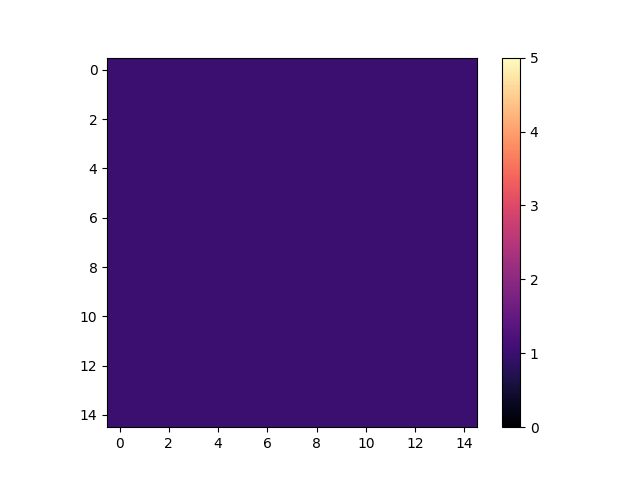

In [ ]:
from matplotlib import animation as animation

%matplotlib ipympl

fig, ax = plt.subplots(1,1)
ims = []
for i in range(len(show_sim)):
    im = ax.imshow(show_sim[i],cmap='magma',vmax=5,vmin=0)
    ims.append([im])

an = animation.ArtistAnimation(fig, ims, interval=150, blit=True, repeat_delay=500)
fig.colorbar(im)

#print(simulation[40,2,10])


Start of my testing

In [ ]:
print(show_sim[1,2,1])

0.0


In [ ]:
simulation[2,2,1]

array([0., 0., 0.])